In [1]:
from collections import defaultdict
from itertools import combinations

def generate_masks(k, d):
    """
    生成所有长度为 k−d 的采样掩码列表，
    即每个掩码是一个元组，指示要保留的 k-mer 位置。
    """
    return list(combinations(range(k), k - d))

def build_multi_mask_index(reference: str, k: int, d: int):
    """
    为 reference 构建多掩码 LSH 索引。
    返回：
      masks: List[Tuple]  —— 所有采样掩码
      idxs:  List[Dict]  —— 与每个掩码对应的哈希表列表
    """
    masks = generate_masks(k, d)
    print("采样掩码数量：", len(masks))
    # print('masks:', masks)
    idxs = []
    for mask in masks:
        idx = defaultdict(list)
        for i in range(len(reference) - k + 1):
            kmer = reference[i : i + k]
            key = hash(tuple(kmer[pos] for pos in mask))
            # print('masks:', mask, 'kmer:', kmer, 'key:', key)
            idx[key].append(i)
        idxs.append(idx)
    print("索引数量：", len(idxs))
    # print('idxs:', idxs)
    return masks, idxs

def match_multi_mask(query: str, k: int, d: int, masks, idxs):
    """
    用多掩码索引匹配 query 中的所有 k-mer。
    任何与 reference 在 ≤d 处错配的 k-mer，都能在至少一个掩码下命中。
    返回所有 (q_pos, r_pos) 锚点对。
    """
    anchors = set()
    for q in range(len(query) - k + 1):
        kmer = query[q : q + k]
        for mask, idx in zip(masks, idxs):
            key = hash(tuple(kmer[pos] for pos in mask))
            for r in idx.get(key, []):
                anchors.add((q, r))
    return list(anchors)



In [2]:
# ———————— 使用示例 ————————

# 假设：
# reference = "ACTGATCATGATCGTAGCT"  # 长百万级的字符串
# query     = "ACCGAACATGCTCGGAGAT"      # 待比对字符串
def read_sequence_from_file(path: str) -> str:
    """
    从文本文件读取 DNA 序列：
    - 忽略空行和首尾空白
    - 返回纯净的字符串（只包含 A/C/G/T）
    """
    with open(path, "r") as f:
        # 读取每一行，去掉首尾空白，过滤空行
        lines = [line.strip() for line in f if line.strip()]
    # 将多行拼接成一个连续序列
    return "".join(lines)

# 调用示例
reference = read_sequence_from_file("ref1.txt")
query     = read_sequence_from_file("que1.txt")

# reference = read_sequence_from_file("ref2.txt")
# query     = read_sequence_from_file("que2.txt")

print("Reference 长度:", len(reference))
print("Query     长度:", len(query))
k, d      = 11, 2                    # k-mer 长度 ，允许最多 _ 处错配

# 1. 构建索引
masks, idxs = build_multi_mask_index(reference, k, d)

# 2. 在 query 中匹配
anchors = match_multi_mask(query, k, d, masks, idxs)

print("找到的锚点数量：", len(anchors))
print("部分锚点示例：", anchors[:10])
for i, (q_pos, r_pos) in enumerate(anchors[:10], 1):   #索引从1开始计数
    q_kmer = query[q_pos : q_pos + k]
    r_kmer = reference[r_pos : r_pos + k]
    print(f"{i:2d}. query[{q_pos:4d}:{q_pos+k:4d}] = {q_kmer}    "
          f"| reference[{r_pos:4d}:{r_pos+k:4d}] = {r_kmer}")

target_q=788
matches2 = list(filter(lambda x: x[0] == target_q, anchors))
print("Filter 结果：", matches2)

for i, (q_pos, r_pos) in enumerate(matches2, 1):   #索引从1开始计数
    q_kmer = query[q_pos : q_pos + k]
    r_kmer = reference[r_pos : r_pos + k]
    print(f"{i:2d}. query[{q_pos:4d}:{q_pos+k:4d}] = {q_kmer}    "
          f"| reference[{r_pos:4d}:{r_pos+k:4d}] = {r_kmer}")

Reference 长度: 1700
Query     长度: 2500
采样掩码数量： 55
索引数量： 55
找到的锚点数量： 5630
部分锚点示例： [(788, 838), (774, 674), (130, 380), (1513, 1013), (695, 795), (1820, 1170), (533, 733), (1658, 1108), (247, 147), (1096, 846)]
 1. query[ 788: 799] = GTGGCGTTTGC    | reference[ 838: 849] = GTGGCGTTTGC
 2. query[ 774: 785] = CTAGGGCACGA    | reference[ 674: 685] = CTATGGCACAA
 3. query[ 130: 141] = TGGGAAATACT    | reference[ 380: 391] = TCCGAAATACT
 4. query[1513:1524] = TATCTTTCAGC    | reference[1013:1024] = TATCTTTCAGC
 5. query[ 695: 706] = TTGCCCCCGCG    | reference[ 795: 806] = TTGCCCCCGTG
 6. query[1820:1831] = CAGCGCCTGCG    | reference[1170:1181] = GAGCGCTTGCG
 7. query[ 533: 544] = GACGGGTGGCG    | reference[ 733: 744] = GGCGGGTGGCG
 8. query[1658:1669] = CTAAAGGGACG    | reference[1108:1119] = CTAAAGGTACG
 9. query[ 247: 258] = GATGATGCCTA    | reference[ 147: 158] = GATCATGCCTA
10. query[1096:1107] = TGCCCCAGCGC    | reference[ 846: 857] = TGCCCCCGCAC
Filter 结果： [(788, 838), (788, 888), (788, 

In [14]:
aa='ABCDE'
aa[:6]

'ABCDE'

anchor q0=1725, r0=1175


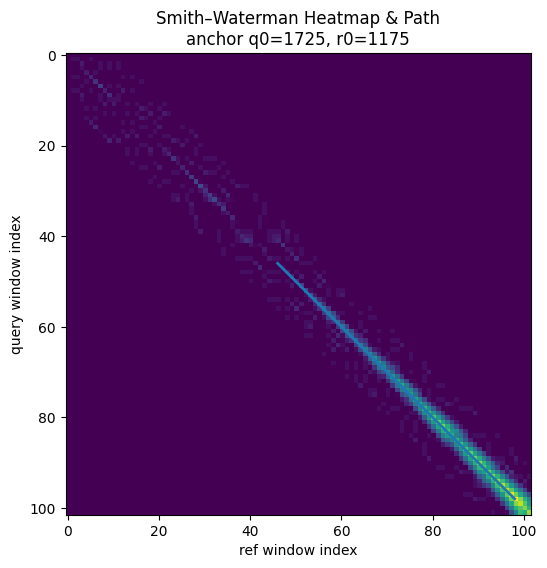

Aligned fragment:
 query[1721:1772] = AGCGCTTGCGTGTTATATAGGAAGAATGGTCAGCTTTGTAAAGGTACGGTAG
 ref  [1171:1222] = AGCGCTTGCGTATTACATAGGACGAATCGTCAGCTTCCTAAAGGGACGGTAG
Best score: 55


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 选一个 anchor，比如第 1 个
q0, r0 = anchors[20]
print(f"anchor q0={q0}, r0={r0}")

def compute_banded_sw_matrix(ref, query, r0, q0,
                             W=50, band=10,
                             match=2, mismatch=-5, gap=-10):
    """
    本函数返回：
      H:    (n+1)x(m+1) 的得分矩阵
      path: 回溯路径列表 [(i1,j1),...,(ik,jk)]
      q_lo, r_lo: 窗口在原始序列中的左边界
    """
    # 定义窗口
    q_lo = max(0, q0 - W); q_hi = min(len(query), q0 + W + 1)
    r_lo = max(0, r0 - W); r_hi = min(len(ref),   r0 + W + 1)
    n, m = q_hi - q_lo, r_hi - r_lo

    # 初始化
    H = np.zeros((n+1, m+1), dtype=int)
    best_score, bi, bj = 0, 0, 0

    # 填表
    for i in range(1, n+1):
        j_start = max(1, i - band)
        j_end   = min(m, i + band)
        for j in range(j_start, j_end+1):
            sc = match if query[q_lo+i-1] == ref[r_lo+j-1] else mismatch
            diag = H[i-1, j-1] + sc
            up   = H[i-1, j]   + gap
            left = H[i,   j-1] + gap
            H[i, j] = val = max(0, diag, up, left)
            if val > best_score:
                best_score, bi, bj = val, i, j

    # 回溯
    path = []
    i, j = bi, bj
    while i>0 and j>0 and H[i, j] > 0:
        path.append((i, j))
        sc = match if query[q_lo+i-1] == ref[r_lo+j-1] else mismatch
        if H[i, j] == H[i-1, j-1] + sc:
            i, j = i-1, j-1
        elif H[i, j] == H[i-1, j] + gap:
            i -= 1
        else:
            j -= 1
    path.append((i, j))
    path.reverse()
    return H, path, q_lo, r_lo

# 计算矩阵和路径
H, path, q_lo, r_lo = compute_banded_sw_matrix(reference, query, r0, q0)

# 可视化得分矩阵和回溯路径
plt.figure(figsize=(6, 6))
plt.imshow(H, aspect='auto')
ys, xs = zip(*path)
plt.plot(xs, ys, linewidth=2)
plt.title(f"Smith–Waterman Heatmap & Path\nanchor q0={q0}, r0={r0}")
plt.xlabel("ref window index")
plt.ylabel("query window index")
plt.show()

# 将回溯结果映射回原始序列坐标并打印
i0, j0 = path[0]
bi, bj = path[-1]
q_st = q_lo + i0
q_en = q_lo + bi - 1
r_st = r_lo + j0
r_en = r_lo + bj - 1

print("Aligned fragment:")
print(f" query[{q_st}:{q_en}] = {query[q_st:q_en+1]}")
print(f" ref  [{r_st}:{r_en}] = {reference[r_st:r_en+1]}")
print("Best score:", H.max())


In [4]:
import numpy as np

def compute_banded_sw_simple(ref, query, r0, q0,
                             W=50, band=10,
                             match=2, mismatch=-5, gap=-10):
    """
    带宽限制的 Smith-Waterman 局部对齐——简洁版
    输入:
      ref, query: DNA 序列
      r0, q0: 种子锚点在 ref/query 上的位置
      W: 窗口半宽度，band: 带宽优化
      match/mismatch/gap: 计分
    输出:
      (q_start, q_end, r_start, r_end, best_score)
    """
    # 1. 定义局部对齐窗口
    q_lo = max(0, q0 - W); q_hi = min(len(query), q0 + W + 1)
    r_lo = max(0, r0 - W); r_hi = min(len(ref),   r0 + W + 1)
    n, m = q_hi - q_lo, r_hi - r_lo

    # 2. DP 矩阵，只存两行滚动优化也可以，这里为了回溯保留全矩阵
    H = np.zeros((n+1, m+1), dtype=int)
    best, bi, bj = 0, 0, 0

    # 3. 填表
    for i in range(1, n+1):
        j0 = max(1, i - band); j1 = min(m, i + band)
        for j in range(j0, j1+1):
            s = match if query[q_lo+i-1] == ref[r_lo+j-1] else mismatch
            v = max(0,
                    H[i-1, j-1] + s,
                    H[i-1, j]   + gap,
                    H[i,   j-1] + gap)
            H[i, j] = v
            if v > best:
                best, bi, bj = v.item(), i, j

    # 4. 回溯到局部起点
    i, j = bi, bj
    while i>0 and j>0 and H[i, j] > 0:
        # 优先判断对角线
        if H[i, j] == H[i-1, j-1] + (match if query[q_lo+i-1]==ref[r_lo+j-1] else mismatch):
            i, j = i-1, j-1
        elif H[i, j] == H[i-1, j] + gap:
            i -= 1
        else:
            j -= 1

    # 5. 映射到全局坐标并返回
    q_start = q_lo + i
    q_end   = q_lo + bi - 1
    r_start = r_lo + j
    r_end   = r_lo + bj - 1
    return (q_start, q_end, r_start, r_end, best)

fragments=[]

for q0,r0 in anchors:
    frag = compute_banded_sw_simple(reference, query, r0, q0,
                                    W=50, band=10,
                                    match=2, mismatch=-5, gap=-10)
    if frag:
        fragments.append(frag)
        
print(len(fragments))
print(fragments[:10])


5630
[(738, 832, 788, 882, 92), (724, 824, 624, 724, 104), (99, 150, 349, 400, 34), (1500, 1560, 1000, 1060, 115), (645, 745, 745, 845, 153), (1813, 1853, 1163, 1203, 40), (507, 548, 707, 748, 77), (1655, 1681, 1105, 1131, 33), (202, 269, 102, 169, 45), (1062, 1136, 812, 886, 73)]


In [5]:
fragments_coords = [(qs, qe, rs, re) for qs, qe, rs, re, _ in fragments]

print(fragments_coords)

[(738, 832, 788, 882), (724, 824, 624, 724), (99, 150, 349, 400), (1500, 1560, 1000, 1060), (645, 745, 745, 845), (1813, 1853, 1163, 1203), (507, 548, 707, 748), (1655, 1681, 1105, 1131), (202, 269, 102, 169), (1062, 1136, 812, 886), (1813, 1879, 1163, 1229), (1402, 1473, 402, 473), (1038, 1100, 688, 750), (1000, 1050, 800, 850), (643, 732, 793, 882), (791, 891, 691, 791), (629, 729, 629, 729), (1710, 1792, 1260, 1342), (1533, 1617, 1033, 1117), (800, 848, 600, 648), (1721, 1772, 1171, 1222), (2026, 2030, 1290, 1294), (571, 632, 621, 682), (219, 260, 319, 360), (1000, 1050, 850, 900), (615, 686, 815, 886), (167, 267, 167, 267), (1440, 1500, 440, 500), (1085, 1170, 735, 820), (1105, 1168, 605, 668), (1848, 1897, 1098, 1147), (1666, 1747, 1166, 1247), (534, 634, 634, 734), (99, 152, 299, 352), (501, 554, 801, 854), (1710, 1735, 1360, 1385), (1054, 1154, 754, 854), (1655, 1742, 1205, 1292), (1807, 1893, 1107, 1193), (237, 300, 237, 300), (813, 899, 813, 899), (800, 899, 650, 749), (656, 7

[(0, 100, 0, 100), (101, 200, 101, 200), (202, 300, 202, 300), (301, 399, 401, 499), (412, 415, 373, 376), (419, 424, 224, 229), (463, 476, 653, 666), (477, 483, 1430, 1436), (493, 498, 63, 68), (500, 505, 404, 409), (507, 607, 607, 707), (608, 708, 708, 808), (712, 809, 712, 809), (810, 899, 710, 799), (906, 910, 68, 72), (917, 930, 619, 632), (945, 951, 1446, 1452), (956, 960, 68, 72), (989, 996, 1406, 1413), (999, 1094, 599, 694), (1095, 1195, 795, 895), (1210, 1218, 588, 596), (1228, 1231, 923, 926), (1239, 1243, 943, 947), (1254, 1262, 529, 537), (1270, 1275, 1383, 1388), (1282, 1286, 263, 267), (1300, 1399, 900, 999), (1402, 1500, 402, 500), (1501, 1601, 1001, 1101), (1602, 1699, 1302, 1399), (1700, 1800, 1200, 1300), (1804, 1810, 590, 596), (1811, 1899, 1111, 1199), (1900, 1997, 1400, 1497), (2008, 2020, 404, 416), (2026, 2030, 1290, 1294), (2031, 2036, 1546, 1551), (2049, 2055, 311, 317), (2061, 2064, 36, 39), (2066, 2073, 900, 907), (2081, 2091, 1287, 1297), (2097, 2105, 980, 

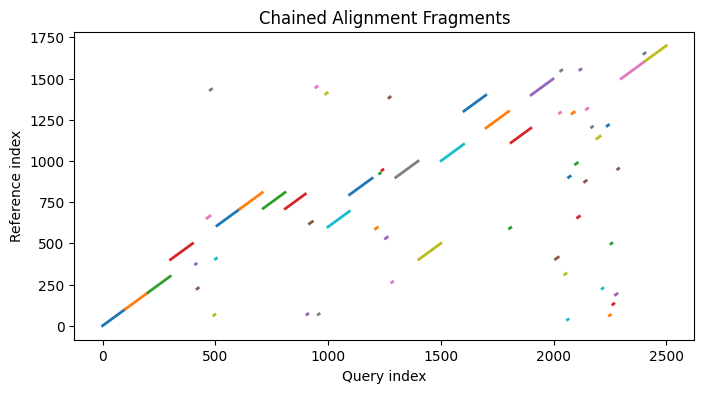

In [8]:
# 假设你已有 fragments 列表，每个元素是 (q_start, q_end, r_start, r_end, score)
# 下面实现贪心链式拼接

def chain_fragments_greedy(fragments):
    """
    输入:
      fragments: List of tuples (q_start, q_end, r_start, r_end, score)
    输出:
      chained: 按 Query 顺序、不重叠的最优贪心链
    """
    # 1. 按 q_start 升序；若相同则按 score 降序
    frags = sorted(fragments, key=lambda x: (x[0], -x[4]))
    chained = []
    ans=[]
    last_q_end = -1
    for qs, qe, rs, re, sc in frags:
        if qs > last_q_end:
            chained.append((qs, qe, rs, re, sc))
            ans.append((qs, qe, rs, re))
            last_q_end = qe
    return chained,ans

# 调用示例
chained ,ans= chain_fragments_greedy(fragments)

print(ans)
print("Greedy Chained Fragments:")
for idx, (qs, qe, rs, re, sc) in enumerate(chained, 1):
    print(f"{idx}. query[{qs}:{qe}] ↔ ref[{rs}:{re}]  score={sc}")

# （可选）可视化每个片段在 Query/Ref 上的位置
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
for qs, qe, rs, re, sc in chained:
    plt.plot([qs, qe], [rs, re], linewidth=2)
plt.xlabel("Query index")
plt.ylabel("Reference index")
plt.title("Chained Alignment Fragments")
plt.show()
